# Exploratory Climate Analysis
### In this notebook climatological data from Honolulu, Hawaii is gathered from a SQLite file to perform the following analysis: 
* Precipitation Analysis
* Station Analysis
* Temperature Analysis

### Main observations:
* The average rainfall (precipitation) of the last year is 0.176462 m
* The most frequent temperatures in WAIHEE is beteween 75 and 80 F
* The average temperature in Hawaii is also between 75 and 80 F
* The average temperature remains almost the same in the last week

# Reflect Tables into SQLAlchemy ORM

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Precipitation Analysis
### For this section the following tasks are accomplished:
* Design a query to retrieve the last 12 months of precipitation data.
* Select only the date and precipitation values.
* Load the query results into a Pandas DataFrame and set the index to the date column.
* Sort the DataFrame values by date.
* Plot the results using the DataFrame plot method.

In [9]:
# Calculate the date 1 year ago from the last data point in the database
measurement_ordered_by_date = session.query(Measurement).order_by(Measurement.date.desc())
last_day = measurement_ordered_by_date.first().date
print(last_day)

2017-08-23


In [10]:
last_12_months = dt.date(2017, 8, 23) - dt.timedelta(days=365)

In [11]:
# Perform a query to retrieve the data and precipitation scores
precipitation_scores = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > last_12_months).all()

In [12]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_scores_df = pd.DataFrame(precipitation_scores)
precipitation_scores_df = precipitation_scores_df.set_index('date')
precipitation_scores_df.head()

,prcp
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


In [13]:
# Sort the dataframe by date
precipitation_scores_df = precipitation_scores_df.sort_index()
precipitation_scores_df.tail()

,prcp
date,
2017-08-22,0.00
2017-08-23,0.08
2017-08-23,0.00
2017-08-23,0.00
2017-08-23,0.45


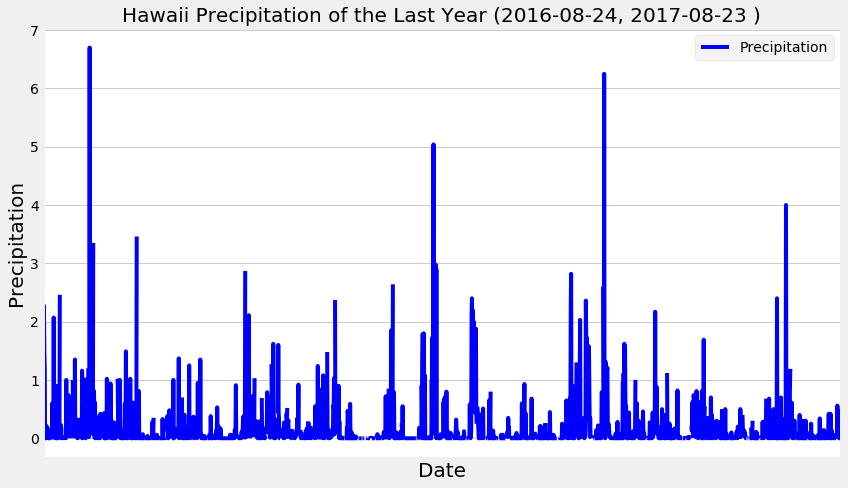

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
#plt.figure(figsize=(20,10))
ax = precipitation_scores_df.plot(color="blue")
plt.gcf().set_size_inches(12, 7)
ax.set_title("Hawaii Precipitation of the Last Year (2016-08-24, 2017-08-23 )", fontsize=20)
ax.set_ylabel('Precipitation',  fontsize=20)
ax.set_xlabel('Date',  fontsize=20)
plt.grid("on")
plt.legend(['Precipitation'], loc="best")
ax.set_facecolor('w')
plt.xticks([], [])
plt.tight_layout()
plt.savefig("./Images/Precipitation_plot.png")
plt.show()

In [15]:
## Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_scores_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis
### For this section the following tasks are accomplished:
* Design a query to calculate the total number of stations.
* Design a query to find the most active stations.
* List the stations and observation counts in descending order.
* Which station has the highest number of observations?
* Design a query to retrieve the last 12 months of temperature observation data (tobs).
* Filter by the station with the highest number of observations.
* Plot the results as a histogram with bins=12.

In [16]:
# Design a query to show how many stations are available in this dataset?
number_of_stations = session.query(Station).count() 
number_of_stations

9

In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()

print(type(active_stations))
active_stations

<class 'list'>


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station = active_stations[0][0]
min_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == most_active_station).all()
max_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == most_active_station).all()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).all()
print(f"The lowest temperature is{min_temp}")
print(f"The highest temperature is{max_temp}")
print(f"The average temperature is{avg_temp}")

The lowest temperature is[(54.0,)]
The highest temperature is[(85.0,)]
The average temperature is[(71.66378066378067,)]


In [19]:
# Choose the station with the highest number of temperature observations.
#Query the last 12 months of temperature observation data for this station
temperature_query = session.query(Measurement.station, Measurement.tobs).\
                filter(Measurement.station == most_active_station).\
                filter(Measurement.date >= last_12_months).all()
temperature_df = pd.DataFrame(temperature_query)
temperature_df.head()

,station,tobs
0,USC00519281,77.0
1,USC00519281,77.0
2,USC00519281,80.0
3,USC00519281,80.0
4,USC00519281,75.0


<function matplotlib.pyplot.show>

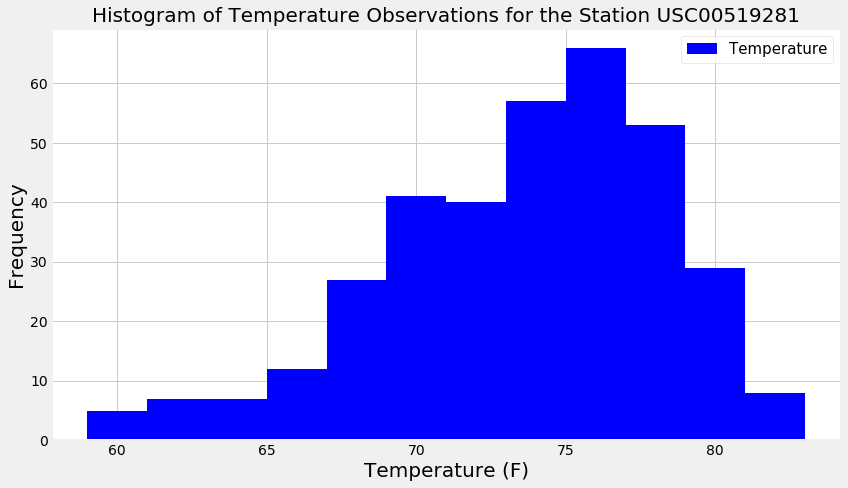

In [20]:
# Plot the results as a histogram
plt.figure(figsize=(12,7))
plt.rcParams['axes.facecolor'] = 'w'
plt.hist(temperature_df.loc[:,"tobs"], label="Temperature", color="blue", bins=12)
plt.title("Histogram of Temperature Observations for the Station " + most_active_station, fontsize=20)
plt.xlabel("Temperature (F)", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.legend(loc="best",fontsize=15)
plt.tight_layout()
plt.savefig("./Images/Temperature_histogram.png")
plt.show

# Temperature Analysis
### For this section the following tasks are accomplished:
* Calculate the min, avg, and max temperatures using the matching dates from the previous year.
* Plot the min, avg, and max temperature from your previous query as a bar chart. Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).
* Calculate the rainfall per weather station using the previous year's matching dates.
* Calculate the daily normals. Nor*mals are the averages for the min, avg, and max temperatures.
* Create a list of dates for your trip in the format %m-%d. Use the daily_normals function to calculate the normals for each date string and append the results to a list.
* Make an area plot for the daily normals.

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_py = calc_temps('2016-08-24', '2017-08-23')
trip_py

[(58.0, 74.57894736842105, 87.0)]

In [23]:
trip_df = pd.DataFrame(trip_py, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
avg_temp = trip_df['Avg Temp']
min_max_temp = trip_df.iloc[0]['Max Temp'] - trip_df.iloc[0]['Min Temp']

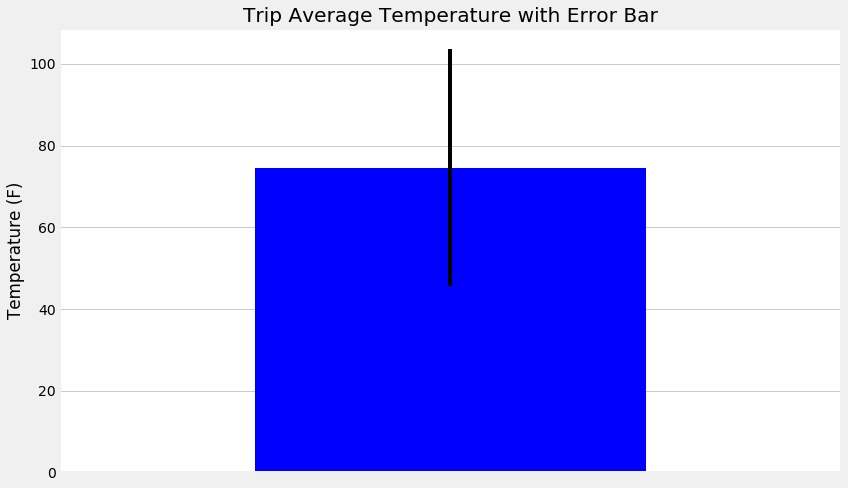

In [24]:
plt.figure(figsize=(12,7))
ax = avg_temp.plot(kind='bar', yerr=min_max_temp, color='b')
ax.set_title("Trip Average Temperature with Error Bar")
ax.set_ylabel('Temperature (F)')
plt.grid("on")
ax.set_facecolor('w')
plt.xticks([], [])
plt.tight_layout()
plt.savefig("./Images/Average_temperature.png")
plt.show()

In [25]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall = session.query(Station.station, 
                  Station.name,
                  func.sum(Measurement.prcp),
                  Station.latitude,
                  Station.longitude,
                  Station.elevation)\
.filter(Measurement.station == Station.station)\
.filter(Measurement.date >= last_12_months)\
.group_by(Station.station)\
.order_by(func.sum(Measurement.prcp).desc()).all()

rainfall= pd.DataFrame(rainfall, columns=['Station', 'Name', 'Precipitation', 'Latitude', 'Longitude', 'Elevation'])
rainfall

,Station,Name,Precipitation,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",147.81,21.33310,-157.80250,152.4
1,USC00519281,"WAIHEE 837.5, HI US",70.03,21.45167,-157.84889,32.9
2,USC00513117,"KANEOHE 838.1, HI US",48.51,21.42340,-157.80150,14.6
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",38.01,21.33556,-157.71139,19.5
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",33.24,21.52130,-157.83740,7.0
5,USC00519397,"WAIKIKI 717.2, HI US",16.09,21.27160,-157.81680,3.0
6,USC00517948,"PEARL CITY, HI US",4.59,21.39340,-157.97510,11.9


In [26]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
last_week = dt.date(2017, 8, 23) - dt.timedelta(days=7)

# Use the start and end date to create a range of dates
daily_normals = session.query(Measurement.date).filter(Measurement.date >= last_12_months).\
    filter(Measurement.date >= last_week).\
    group_by(Measurement.date).\
    order_by(Measurement.date).all()
    
dates=pd.DataFrame(daily_normals)
dates

,date
0,2017-08-16
1,2017-08-17
2,2017-08-18
3,2017-08-19
4,2017-08-20
5,2017-08-21
6,2017-08-22
7,2017-08-23


In [27]:
# Stip off the year and save a list of %m-%d strings
split = dates["date"].str.split("-", n = 1, expand = True)
split

,0,1
0,2017,08-16
1,2017,08-17
2,2017,08-18
3,2017,08-19
4,2017,08-20
5,2017,08-21
6,2017,08-22
7,2017,08-23


In [28]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all() 

In [29]:
# Loop through the list of %m-%d strings and calculate the normals for each date
normals=[]
normals_df = pd.DataFrame(columns=["tmin","tavg","tmax"])
for index, row in split.iterrows():
    normals_df2 = pd.DataFrame(daily_normals(row[1]), columns=["tmin","tavg","tmax"])
    normals_df=pd.concat([normals_df,  normals_df2])
    
normals_df=normals_df.reset_index()
normals_df = normals_df.drop("index", axis=1)
normals_df

,tmin,tavg,tmax
0,69.0,76.080000,83.0
1,69.0,76.125000,83.0
2,70.0,76.923077,84.0
3,69.0,75.946429,85.0
4,68.0,76.452830,82.0
5,67.0,76.400000,83.0
6,69.0,76.471698,84.0
7,67.0,76.692308,87.0


In [30]:
#columns=['tmin', 'tavg', 'tmax']
frames=[normals_df, dates]
daily_normals_date= pd.concat(frames, axis=1, join_axes=[dates.index])
daily_normals_date =daily_normals_date.set_index("date")
daily_normals_date

,tmin,tavg,tmax
date,,,
2017-08-16,69.0,76.080000,83.0
2017-08-17,69.0,76.125000,83.0
2017-08-18,70.0,76.923077,84.0
2017-08-19,69.0,75.946429,85.0
2017-08-20,68.0,76.452830,82.0
2017-08-21,67.0,76.400000,83.0
2017-08-22,69.0,76.471698,84.0
2017-08-23,67.0,76.692308,87.0


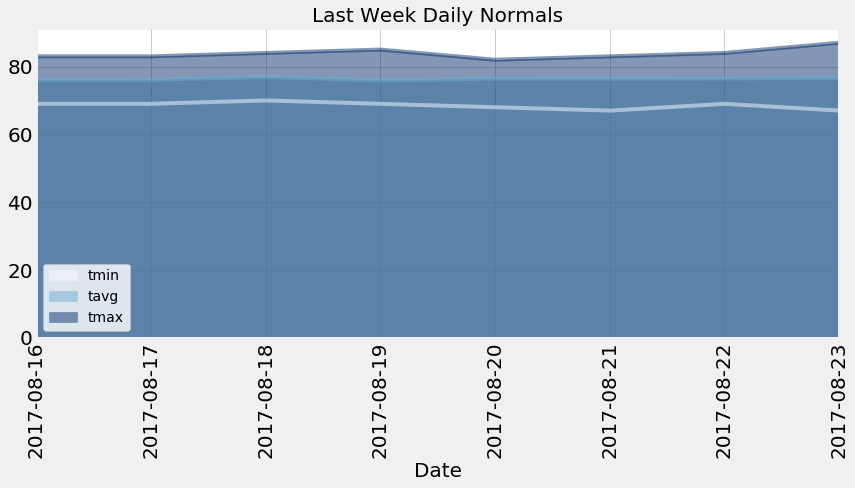

In [31]:
# Plot the daily normals as an area plot with `stacked=False`
ax = daily_normals_date.plot(kind="area",stacked=False, colormap='Blues')
plt.gcf().set_size_inches(12, 7)
ax.set_title("Last Week Daily Normals",  fontsize=20)
ax.set_xticklabels(daily_normals_date.index, rotation=90,  fontsize=20)
plt.xlabel("Date", fontsize=20)
plt.tight_layout()
ax.tick_params(axis='both', labelsize=20)
plt.savefig("./Images/Daily_Normals.png")
plt.show()